In [1]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
import osmnx as ox
from geopy.distance import geodesic

from shapely.geometry import GeometryCollection

from shapely.geometry import GeometryCollection

def split_linestrings_at_intersections(geometries):
    """Split LineStrings at their intersections."""
    all_intersection_points = []

    # Collect all intersection points
    for i, line1 in enumerate(geometries):
        if not isinstance(line1, LineString):
            continue
        for j, line2 in enumerate(geometries):
            if i >= j:  # Avoid duplicate checks
                continue
            if line1.intersects(line2):
                intersection = line1.intersection(line2)
                if intersection.is_empty:
                    continue
                if intersection.geom_type == "Point":
                    all_intersection_points.append(intersection)
                # elif intersection.geom_type == "MultiPoint":
                #     all_intersection_points.extend(intersection.geoms)

    # Split each LineString at intersection points
    new_geometries = []
    for line in geometries:
        if isinstance(line, LineString):
            split_points = [pt for pt in all_intersection_points if line.intersects(pt)]
            if split_points:
                # Perform the split
                split_result = split(line, MultiPoint(split_points))
                if isinstance(split_result, GeometryCollection):
                    # Extract LineString components from the GeometryCollection
                    for geom in split_result.geoms:
                        if isinstance(geom, LineString):
                            new_geometries.append(geom)
                else:
                    new_geometries.extend(split_result)
            else:
                new_geometries.append(line)
    return new_geometries


def create_graph_from_geometries(geometries):
    """Create a graph representation from LineStrings."""
    G = nx.Graph()
    for line in geometries:
        if isinstance(line, LineString):
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                node_start = coords[i]
                node_end = coords[i + 1]

                # Calculate distance
                distance = geodesic((node_start[1], node_start[0]), (node_end[1], node_end[0])).meters

                # Add nodes and edge
                G.add_node(node_start, x=node_start[0], y=node_start[1])
                G.add_node(node_end, x=node_end[0], y=node_end[1])
                G.add_edge(node_start, node_end, length=distance)
    return G

# Load your data
latitude = 52.69238
longitude = 16.78041
radius = 3000  # Buffer radius in meters
pavement_tags = {"highway": ["footway", "track", "path", "cycleway"]}
pavements_gdf = ox.features.features_from_point((latitude, longitude), tags=pavement_tags, dist=radius)

# Split LineStrings at intersections
split_geometries = split_linestrings_at_intersections(pavements_gdf.geometry)

# Create the graph
G = create_graph_from_geometries(split_geometries)


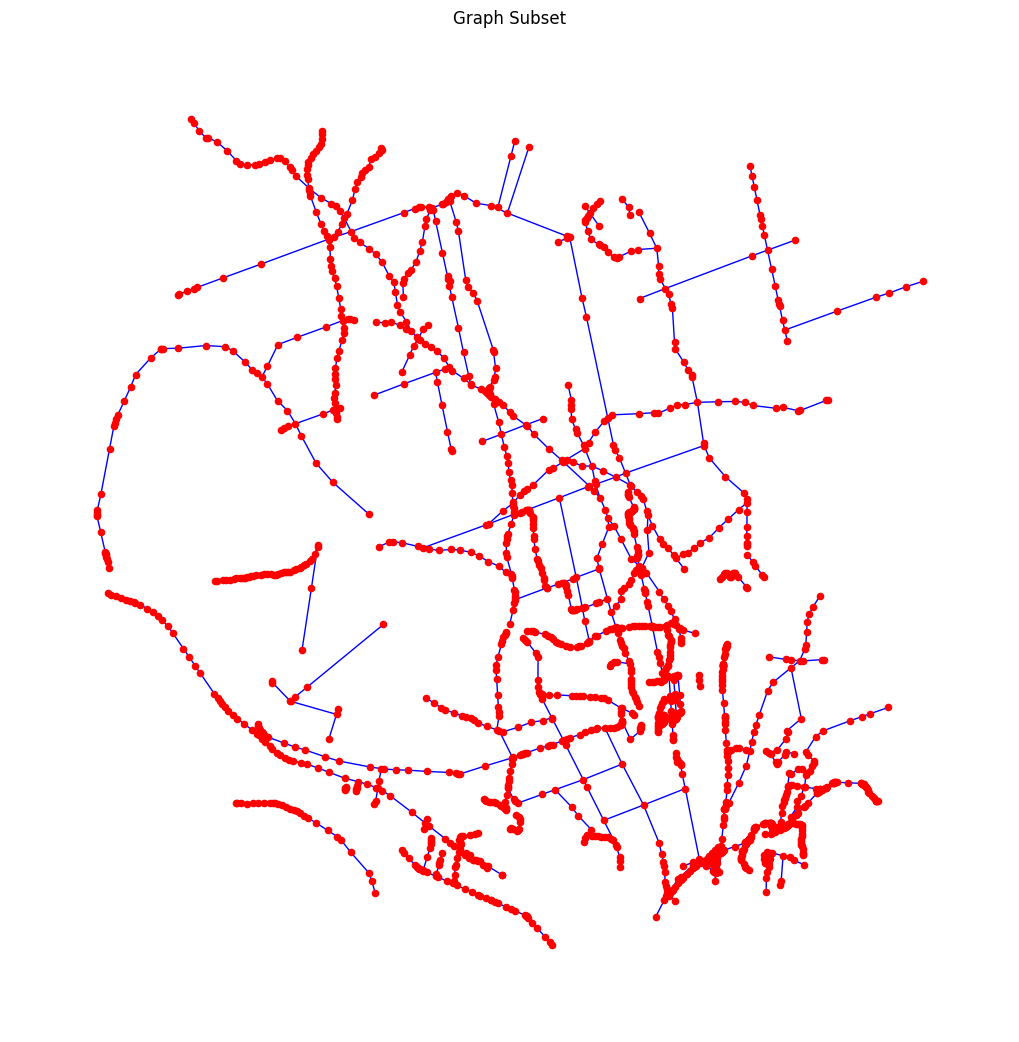

In [3]:
import matplotlib.pyplot as plt

def plot_graph_subset(G, center_node=None, radius=0.01):
    """
    Plot a small subset of a graph centered around a given node or first node.
    :param G: NetworkX graph
    :param center_node: Node to center the subset around (default: first node)
    :param radius: Radius (in coordinate units) for selecting nearby nodes
    """
    # Select a center node if not provided
    if center_node is None:
        center_node = list(G.nodes)[0]

    # Get the position of the center node
    center_x, center_y = G.nodes[center_node]['x'], G.nodes[center_node]['y']

    # Filter nodes within the specified radius
    subset_nodes = [
        n for n, attrs in G.nodes(data=True)
        if abs(attrs['x'] - center_x) <= radius and abs(attrs['y'] - center_y) <= radius
    ]

    # Create a subgraph from these nodes
    subgraph = G.subgraph(subset_nodes)

    # Extract positions for plotting
    pos = {n: (attrs['x'], attrs['y']) for n, attrs in subgraph.nodes(data=True)}

    # Plot the subgraph
    plt.figure(figsize=(10, 10))
    nx.draw(
        subgraph, pos, with_labels=False, node_size=20, node_color="red", edge_color="blue"
    )
    plt.title("Graph Subset")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Plot a subset of the graph
plot_graph_subset(G, list(G.nodes)[8], radius=1.009)  # Adjust radius for desired subset size


In [5]:
edges = 0
for node in G.nodes:
    edges += len(G.edges(node)) if len(G.edges(node)) >= 3 else 0
print(edges)

445


In [ ]:
import pickle

pickle.dump(G, open("graph.pkl", "wb"))

G = pickle.load(open("../graph.pkl", "rb"))
print(len(G.nodes))

1616


/var/folders/w6/p9pm_4m92h77wj7cvp57dtq00000gn/T/ipykernel_60541/678302745.py:3: ResourceWarning: unclosed file <_io.BufferedWriter name='graph.dupa'>
  pickle.dump(G, open("graph.dupa", "wb"))
/var/folders/w6/p9pm_4m92h77wj7cvp57dtq00000gn/T/ipykernel_60541/678302745.py:5: ResourceWarning: unclosed file <_io.BufferedReader name='../graph.pkl'>
  G = pickle.load(open("../graph.pkl", "rb"))


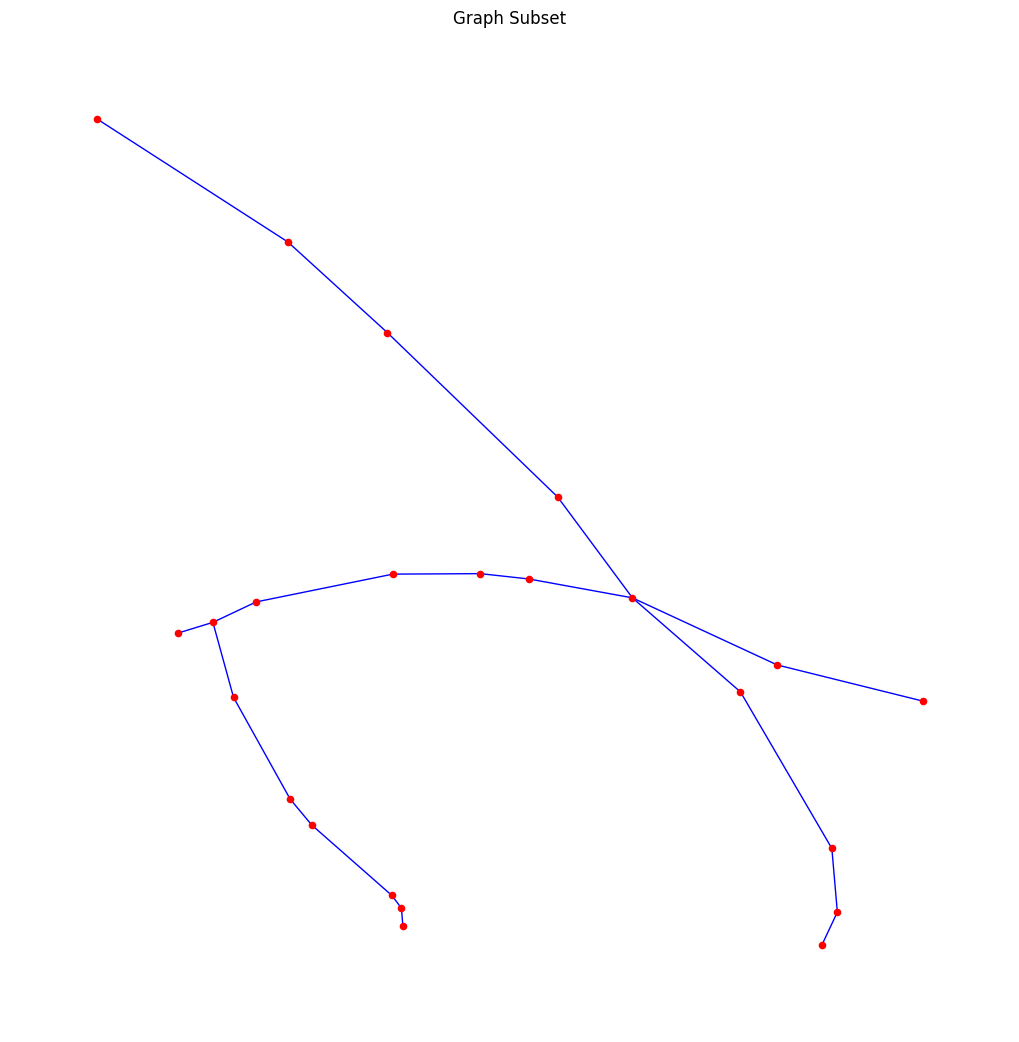

In [ ]:

plot_graph_subset(G, list(G.nodes)[8], radius=0.002)  # Adjust radius for desired subset size

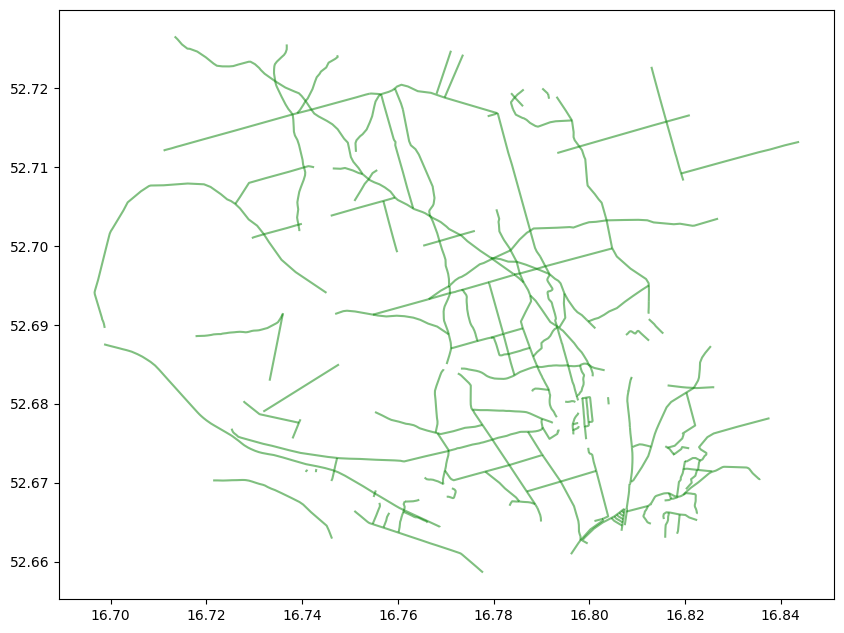

In [4]:
ax = pavements_gdf.plot(color="green", alpha=0.5, figsize=(10, 10), edgecolor="darkgreen")

In [7]:
pavements_gdf = pavements_gdf.explode(index_parts=True)

In [ ]:
pavements_gdf = pavements_gdf[pavements_gdf.geometry.type == "LineString"]  # Filter LineStrings only

In [8]:
list(pavements_gdf.iloc[0].geometry.coords)

[(16.794616, 52.6942747),
 (16.7948176, 52.6939463),
 (16.7956077, 52.6930875),
 (16.7968823, 52.6919928),
 (16.7975305, 52.6915822),
 (16.7984627, 52.6912114),
 (16.7994256, 52.6906367)]

In [9]:
start_points = pavements_gdf.geometry.apply(lambda geom: Point(geom.coords[0]))
end_points = pavements_gdf.geometry.apply(lambda geom: Point(geom.coords[-1]))

In [10]:
nodes_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(pd.concat([start_points, end_points])).drop_duplicates())
nodes_gdf = nodes_gdf.reset_index(drop=True)

In [11]:
# Add x and y columns (longitude and latitude)
nodes_gdf["x"] = nodes_gdf.geometry.x
nodes_gdf["y"] = nodes_gdf.geometry.y

# Assign a unique ID to each node
nodes_gdf["node_id"] = nodes_gdf.index

In [12]:
pavements_gdf

highway  \
element_type osmid                  
way          158195144  0   track   
             158195169  0   track   
             158195190  0   track   
             158195202  0   track   
             158195225  0   track   
...                           ...   
             1331288829 0   track   
             1331288830 0    path   
             1331288831 0   track   
             1331288832 0   track   
             1331288847 0   track   

                                                                       nodes  \
element_type osmid                                                             
way          158195144  0  [1704257876, 1704257874, 1704257741, 170425774...   
             158195169  0  [1704257832, 9688634527, 1704257837, 170425786...   
             158195190  0  [2964357940, 2964357939, 2964357938, 296435793...   
             158195202  0  [1704257943, 12317850181, 1704257952, 51945663...   
             158195225  0  [1704257832, 4290713425, 4290713426, 170425807...   
...                                                                      ...   
             1331288829 0  [12317850199, 12317850200, 12317850201, 123178...   
             1331288830 0  [12317850212, 12317850213, 12317850214, 123178...   
             1331288831 0  [12317850202, 12317850210, 12317850211, 123178...   
             1331288832 0  [12317850212, 12317850222, 12317850223, 123178...   
             1331288847 0             [1704258000, 12317850294, 12317850295]   

                                         source surface tracktype  \
element_type osmid                                                  
way          158195144  0  European Urban Atlas  ground    grade3   
             158195169  0  European Urban Atlas     NaN       NaN   
             158195190  0  European Urban Atlas     NaN    grade2   
             158195202  0  European Urban Atlas     NaN       NaN   
             158195225  0  European Urban Atlas    sand       NaN   
...                                         ...     ...       ...   
             1331288829 0                   NaN     NaN       NaN   
             1331288830 0                   NaN  ground       NaN   
             1331288831 0                   NaN     NaN       NaN   
             1331288832 0                   NaN     NaN       NaN   
             1331288847 0                   NaN     NaN       NaN   

                          unsigned_ref foot horse segregated bicycle  \
element_type osmid                                                     
way          158195144  0          NaN  NaN   NaN        NaN     NaN   
             158195169  0          NaN  NaN   NaN        NaN     NaN   
             158195190  0          NaN  NaN   NaN        NaN     NaN   
             158195202  0          NaN  NaN   NaN        NaN     NaN   
             158195225  0       2058 P  NaN   NaN        NaN     NaN   
...                                ...  ...   ...        ...     ...   
             1331288829 0          NaN  NaN   NaN        NaN     NaN   
             1331288830 0          NaN  NaN   NaN        NaN     NaN   
             1331288831 0          NaN  NaN   NaN        NaN     NaN   
             1331288832 0          NaN  NaN   NaN        NaN     NaN   
             1331288847 0          NaN  NaN   NaN        NaN     NaN   

                                                                    geometry  
element_type osmid                                                            
way          158195144  0  LINESTRING (16.79462 52.69427, 16.79482 52.693...  
             158195169  0  LINESTRING (16.79988 52.68496, 16.79957 52.685...  
             158195190  0  LINESTRING (16.81296 52.67453, 16.81223 52.674...  
             158195202  0  LINESTRING (16.79937 52.67549, 16.79935 52.675...  
             158195225  0  LINESTRING (16.79988 52.68496, 16.79944 52.685...  
...                                                                      ...  
             1331288829 0  LINESTRIN

In [13]:
nodes_gdf

,geometry,x,y,node_id
0,POINT (16.79462 52.69427),16.794616,52.694275,0
1,POINT (16.79988 52.68496),16.799880,52.684957,1
2,POINT (16.81296 52.67453),16.812959,52.674535,2
3,POINT (16.79937 52.67549),16.799370,52.675491,3
4,POINT (16.78912 52.66684),16.789116,52.666837,4
...,...,...,...,...
257,POINT (16.80675 52.66389),16.806749,52.663891,257
258,POINT (16.79784 52.67715),16.797837,52.677149,258
259,POINT (16.79776 52.67885),16.797759,52.678846,259
260,POINT (16.79769 52.67754),16.797693,52.677539,260


In [14]:
def map_point_to_node_id(point, nodes):
    return nodes[nodes.geometry == point].iloc[0]["node_id"]

pavements_gdf["u"] = pavements_gdf.geometry.apply(lambda geom: map_point_to_node_id(Point(geom.coords[0]), nodes_gdf))
pavements_gdf["v"] = pavements_gdf.geometry.apply(lambda geom: map_point_to_node_id(Point(geom.coords[-1]), nodes_gdf))


In [ ]:
G = ox.utils_graph.graph_from_gdfs(nodes_gdf, pavements_gdf)

In [ ]:
# adjacency matrix
import networkx as nx
A = nx.adjacency_matrix(G).todense()


In [ ]:
# sum of rows in A
G.nodes

In [ ]:
# show adjacency matrix
# import networkx as nx
# adj = nx.adjacency_matrix(G).todense()


In [ ]:
# Step 6: Visualization (optional)
ox.plot_graph(G, node_color="red", edge_color="blue", figsize=(10, 10))

In [43]:
# extract one linestring
line = pavements_gdf.iloc[0].geometry

In [44]:
print(line.coords[:])

[(16.794616, 52.6942747), (16.7948176, 52.6939463), (16.7956077, 52.6930875), (16.7968823, 52.6919928), (16.7975305, 52.6915822), (16.7984627, 52.6912114), (16.7994256, 52.6906367)]


/Users/samuel/Documents/planet-on-2024/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

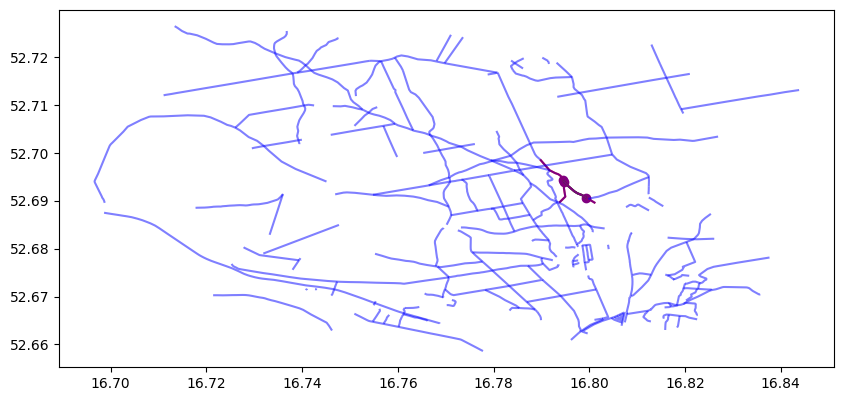

In [45]:
# find intersecting linestrings
intersections = pavements_gdf[pavements_gdf.intersects(line)]

intersections['point'] = intersections.apply(lambda row: line.intersection(row.geometry), axis=1)
# plot intersection points with lines
ax = intersections.plot(color="red", figsize=(10, 10))

pavements_gdf.plot(ax=ax, color="blue", alpha=0.5)

# plot line as green
gpd.GeoSeries([line]).plot(ax=ax, color="green")
intersections['point'].plot(ax=ax, color="purple")

In [46]:
intersections

highway  \
element_type osmid                 
way          158195144 0   track   
             290888258 0   track   
             522846834 0   track   
             522846842 0   track   

                                                                      nodes  \
element_type osmid                                                            
way          158195144 0  [1704257876, 1704257874, 1704257741, 170425774...   
             290888258 0  [1704257876, 2943844619, 2943844620, 294384462...   
             522846834 0   [1704257867, 1704257869, 1704257871, 1704257874]   
             522846842 0               [5091399356, 5091399317, 5289588950]   

                                        source          surface tracktype  \
element_type osmid                                                          
way          158195144 0  European Urban Atlas           ground    grade3   
             290888258 0                   NaN              NaN       NaN   
             522846834 0  European Urban Atlas  concrete:plates    grade1   
             522846842 0  European Urban Atlas           ground    grade3   

                         unsigned_ref bicycle foot segregated smoothness  \
element_type osmid                                                         
way          158195144 0          NaN     NaN  NaN        NaN        NaN   
             290888258 0          NaN     NaN  NaN        NaN        NaN   
             522846834 0          NaN     NaN  NaN        NaN        NaN   
             522846842 0          NaN     NaN  NaN        NaN        NaN   

                         motor_vehicle access footway name horse  \
element_type osmid                                                 
way          158195144 0           NaN    NaN     NaN  NaN   NaN   
             290888258 0           NaN    NaN     NaN  NaN   NaN   
             522846834 0           NaN    NaN     NaN  NaN   NaN   
             522846842 0           NaN    NaN     NaN  NaN   NaN   

                                                                   geometry  \
element_type osmid                                                            
way          158195144 0  LINESTRING (16.79462 52.69427, 16.79482 52.693...   
             290888258 0  LINESTRING (16.79462 52.69427, 16.79401 52.695...   
             522846834 0  LINESTRING (16.79373 52.68962, 16.79500 52.690...   
             522846842 0  LINESTRING (16.79943 52.69064, 16.79981 52.690...   

                           u    v  \
element_type osmid                  
way          158195144 0   0   54   
             290888258 0   0   11   
             522846834 0  52  182   
             522846842 0  54  184   

                                                                      point  
element_type osmid                                                           
way          158195144 0  MULTILINESTRING ((16.79462 52.69427, 16.79482 ...  
             290888258 0                          POINT (16.79462 52.69427)  
             522846834 0                          POINT (16.79482 52.69395)  
             522846842 0                          POINT (16.79943 52.69064)